[← Back to Index](https://makeabilitylab.github.io/physcomp/signals)

# Overview
In this Notebook, you will write a shape-based gesture classifier (or sometimes called a template-based classifier)—that is, a classifier that measures the similarity between time-series signals. This is in contrast to a feature-based classifier, which extracts features from the signal (*e.g.,* mean, variance, strongest frequency) to train a model for classification. We'll do that in a future notebook.

Importantly, for this assignment, you will be working with **pre-segmented** data—that is, we'll use the segmentation boundaries from the "ground truth" data collected with the GestureRecorder. This will enable us to focus purely on the classification aspects of this assignment rather than intermixing segmentation + classification.

## GestureRecorder data collection
![GestureRecorder animated gif showing a sample data collection](https://raw.githubusercontent.com/makeabilitylab/physcomp/master/signals/assets/movies/GestureRecorder_Trim_800_5fps_compressed90.gif)

We wrote a gesture data collection system composed of two parts ([source code](https://github.com/makeabilitylab/arduino/tree/master/Processing/GestureRecorder)):
1. An **Arduino program** called [LIS3DHGestureRecorder.ino](https://github.com/makeabilitylab/arduino/blob/master/Processing/GestureRecorder/Arduino/LIS3DHGestureRecorder/LIS3DHGestureRecorder.ino) that writes out accelerometer data in a CSV format on Serial: timestamp, x, y, z at ~90 Hz. The program also sends a button state to trigger data recording in the GestureRecorder program, described next.
2. A **Processing program** called [GestureRecorder.pde](https://github.com/makeabilitylab/arduino/blob/master/Processing/GestureRecorder/GestureRecorder.pde), which runs on your Windows, Mac, or Linux machine, reads the Serial data from the Arduino program, and steps you through the gesture data collection process, including: (1) prompting you to perform gestures; (2) saving those gestures to the filesystem (in a directory called `GestureLogs`). You must download and install [Processing](https://processing.org/download/) for this program to work.

Here's a video demonstration of me using GestureRecorder:

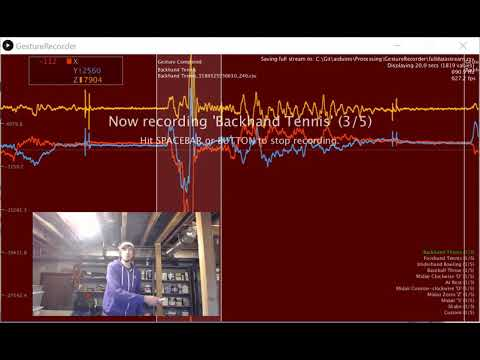

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('z9OeVyGdbVY', width=800, height=500)

## Using this notebook

The cells are written such that they should be executed in order.

### Data from GestureRecorder

This Notebook reads gesture logs from the `GestureLogs` folder, which must exist in the same dir as this `.ipynb`. Inside of `GestureLogs`, you should have one or more sub-directories like `JonGestures` or `FrankGestures`, which were created by the `GestureRecorder.pde.` 

We have included one GestureLog folder already called `JonGestures`. In addition, we have a sample of log files from previous classes in the folder [`ADXL335GestureLogs`](https://github.com/makeabilitylab/signals/tree/master/Projects/GestureRecognizer/ADXL335GestureLogs); however, these were recorded with the [ADXL335 accelerometer](https://www.adafruit.com/product/163) rather than the [LIS3DH accelerometer](https://www.adafruit.com/product/2809). So, normalized versions of the gesture signals should be similar but non-normalized versions will have different y-amplitudes. 

### The gesturerec package

We wrote the `gesturerec` package to handle parsing the sensor stream data and to help run basic classification experiments. You can and should look over the code in the [gesturerec](https://github.com/makeabilitylab/signals/tree/master/Projects/GestureRecognizer/gesturerec) folder, particularly `data.py` and `experiments.py`. Feel free to edit this code!

It might look a bit complicated at first but you'll build up a stronger understanding as you look over this Notebook and start writing analysis and visualization code.

There are three primary data structure objects in `gesturerec.data`:
1. At the top level, we have a `GestureSet`, which contains all of the gesture data for a person.
2. Each `GestureSet` object contains a `dict()` mapping gesture names to trials (recall that in the assignment, you had to collect 5 trials of 11 gestures)
3. Each `Trial` object contains the sensor data (`SensorData`) for that trial, which is the accelerometer data (x, y, z, and a computed magnitude)

Given that there can be multiple loaded gesture sets, we have a global object called `map_gesture_sets` that maps the gesture set name to the `GestureSet` object.

## Your TODOs

In general, your coding TODOs are marked below with the word `TODO`. Search for the word "TODO" using your web browser's find functionality (`ctrl-f` or `cmd-f`).

1. Record your own gesture set using [GestureRecorder](https://github.com/makeabilitylab/arduino/tree/master/Processing/GestureRecorder). Name your gesture log folder and put it in `GestureLogs`
2. Then **visualize and explore** the data
3. Think about, experiment, and write code for **preprocessing** the data.
4. Think about, experiment, and write code for **comparing two signals** and returning a **similarity score** (lower is better)
5. Write a k-folds cross-validation method
6. Run experiments and iterate on your algorithms (take notes on what you've found)
7. Write-up your results for your gesture set and for others in the course.

You should be able to get above 90% classification accuracies but aim for 100%, of course! :)

## Misc

### How To Navigate This Notebook
I strongly encourage you to install the [toc2 extension](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html), which will give you a navigable table of contents (based on markdown) on a side pane and drop-down menu.

### Writing Docstrings
To help with commenting your functions, it's helpful to write [Docstrings](https://www.python.org/dev/peps/pep-0257/). More [here](https://www.datacamp.com/community/tutorials/docstrings-python).

### Dynamic Time Warping Library
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
You could also write your own DTW algorithm from scratch (*e.g.,* [link](https://musicinformationretrieval.com/dtw.html)).

# Imports

In [168]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
from sklearn import preprocessing
import random
import os
import math
import makelab
from makelab import signal
from scipy.spatial import distance
import time

# Fastdtw code sourced from https://github.com/slaypni/fastdtw
from fastdtw import fastdtw

# We wrote this gesturerec package for the class
# It provides some useful data structures for the accelerometer signal
# and running experiments so you can focus on writing classification code, 
# evaluating your solutions, and iterating 
import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.gesturestream as grstream
from gesturerec.data import SensorData
from gesturerec.data import GestureSet
from gesturerec.experiments import Experiments
from gesturerec.experiments import ClassificationResults
from gesturerec.experiments import TrialClassificationResult

# Load the data

In [3]:
# Load the data
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Emma")
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)



Found the following gesture log sub-directories
['NickGestures', 'NanGestures', 'StacyGestures', 'AnjaliGestures', 'Paf2Gestures', 'AGestures', 'ThweidGestures', 'AlexandraGestures', 'JaeHGestures', 'DustinGestures', 'JonGestures', 'MattCGestures', 'MikaelGestures', 'AlexisGestures', 'ShaunGestures', 'SamuelRGestures', 'JustinGestures', 'JasonGestures', 'NeilGestures', 'JuliaBGestures', 'BryanGestures', 'ClayGestures', 'WolfsonGestures', 'NooseGestures', 'EmmaGestures', 'BrettGestures']
Creating a GestureSet object for path './GestureLogs/NickGestures'
Found 55 csv files in ./GestureLogs/NickGestures
Found 11 gestures
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Drinking Coffee'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 t

Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Shake'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Custom'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Baseball Throw'
Max trial length across all gesture is 'At Rest' Trial 4 with 506 sensor events.
Avg samples/sec across 55 sensor files: 84.0
Avg sample length across 55 sensor files: 2.3s

Creating a GestureSet object for path './GestureLogs/MikaelGestures'
Found 55 csv files in ./GestureLogs/MikaelGestures
Found 11 gestures
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Custom'
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials 

Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair Counter-clockwise 'O''
Max trial length across all gesture is 'Baseball Throw' Trial 4 with 437 sensor events.
Avg samples/sec across 55 sensor files: 91.2
Avg sample length across 55 sensor files: 3.2s

Creating a GestureSet object for path './GestureLogs/EmmaGestures'
Found 55 csv files in ./GestureLogs/EmmaGestures
Found 11 gestures
Found 5 trials for 'Shake'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Star'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'At Rest'
Max trial length across all gesture is 'Star' Tri

The `map_gesture_sets` is a `dict` object and is our primary data structure: it maps gesture dir names to `GestureSet` objects. There's truly nothing special here. But we realize our data structures do require a learning ramp-up. Let's iterate through the GestureSets.

In [4]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is: {selected_gesture_set.name}")

We have 26 gesture sets:
 NickGestures with 55 trials
 NanGestures with 55 trials
 StacyGestures with 55 trials
 AnjaliGestures with 55 trials
 Paf2Gestures with 55 trials
 AGestures with 55 trials
 ThweidGestures with 55 trials
 AlexandraGestures with 55 trials
 JaeHGestures with 55 trials
 DustinGestures with 55 trials
 JonGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 AlexisGestures with 55 trials
 ShaunGestures with 55 trials
 SamuelRGestures with 55 trials
 JustinGestures with 55 trials
 JasonGestures with 55 trials
 NeilGestures with 55 trials
 JuliaBGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 WolfsonGestures with 55 trials
 NooseGestures with 55 trials
 EmmaGestures with 55 trials
 BrettGestures with 55 trials
The selected gesture set is: EmmaGestures


# Preprocess the data

You'll want to write your own preprocessing algorithms in `preprocess_signal`. The preprocessed data is stored in SensorData's `x_p`, `y_p`, `z_p`, and `mag_p` while the raw data is `x`, `y`, `z`, and `mag`.

In [22]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    
    '''Detrend the signal'''
    s_detrended = sp.signal.detrend(s) 

    filter_order = 1
    low_pass_cutoff_freq = 2
    sampling_rate = 42.0
    nyquist_freq = 0.5 * sampling_rate
    
    '''Apply butterworth filter to detrended signal'''
    sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
    mag_butter_filter2 = signal.sosfilt(sos, s_detrended)
    
    ''' Resample the signal to 50% of original to increase processing speed '''
    s_resampled = signal.resample(mag_butter_filter2, (int)(len(mag_butter_filter2)*0.5))
    
    return s_resampled

def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)

# Explore the data
We have some example visualizations to help you explore the data (and the result of your preprocessing algorithms) but we expect that you'll want (and need) to write more. Exploring data is fun!

For this, we'll use the `selected_gesture_set` variable, which was set during load. You could change it to something else, however, and rerun these cells. For example:

```
selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets)
```

or

```
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
```

## Plot a random gesture
Let's start by plotting the `x`, `y`, `z` and `mag` for all the trials of a random gesture for the `selected_gesture_set`

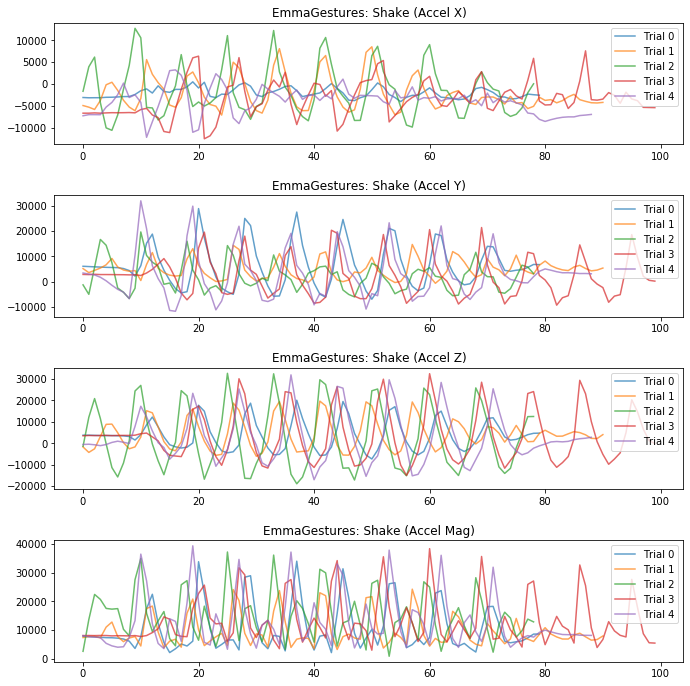

In [23]:
# For example, 
rand_gesture_name = selected_gesture_set.get_random_gesture_name()

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(4, figsize=(10, 10)) #figsize is width, height
fig.tight_layout(pad=3) # add vertical spacing
gesture_trials = selected_gesture_set.get_trials_for_gesture(rand_gesture_name)
trial_num = 0
for trial in gesture_trials:
    axes[0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
    axes[1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
    axes[2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
    axes[3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
    trial_num = trial_num + 1

# set the title and show the legend
axes[0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel X)")
axes[0].legend();

axes[1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Y)")
axes[1].legend();

axes[2].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Z)")
axes[2].legend();

axes[3].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Mag)")
axes[3].legend();

## Plot raw and preprocessed signal

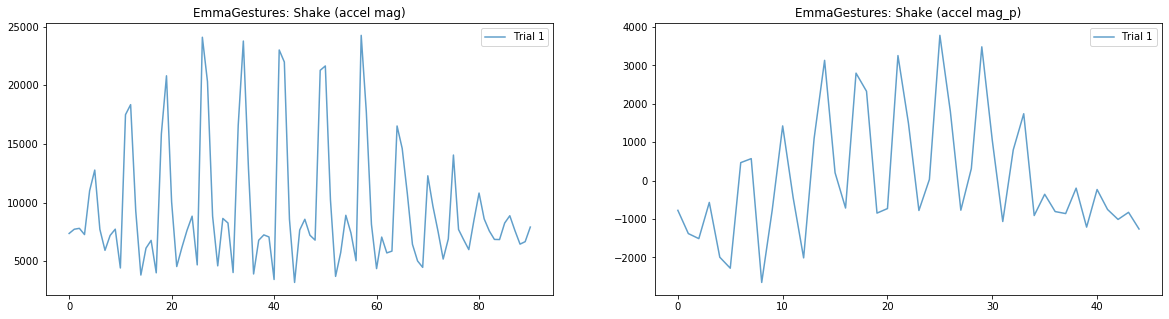

In [24]:
# Now let's plot both the raw and processed signal of a random gesture 
# pulled from a random trial. This helps us explore how our preprocessing
# is working
rand_gesture_name = selected_gesture_set.get_random_gesture_name()

# We'll make a 1x2 grid of plots, so pass 1,2 to subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5)) #figsize is width, height
rand_trial = selected_gesture_set.get_random_trial_for_gesture(rand_gesture_name)

axes[0].plot(rand_trial.accel.mag, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag)")
axes[0].legend()

axes[1].plot(rand_trial.accel.mag_p, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag_p)")
axes[1].legend(); # include semi-colon to hide return output from legend(), <matplotlib.legend.Legend at 0x263de45dd30>

## Plot giant grid of signals
Now let's go a bit crazy and plot all of the signals in a giant grid. What patterns do you observe? Do the signals look different? Do you think you could write a classifier to differentiate them?

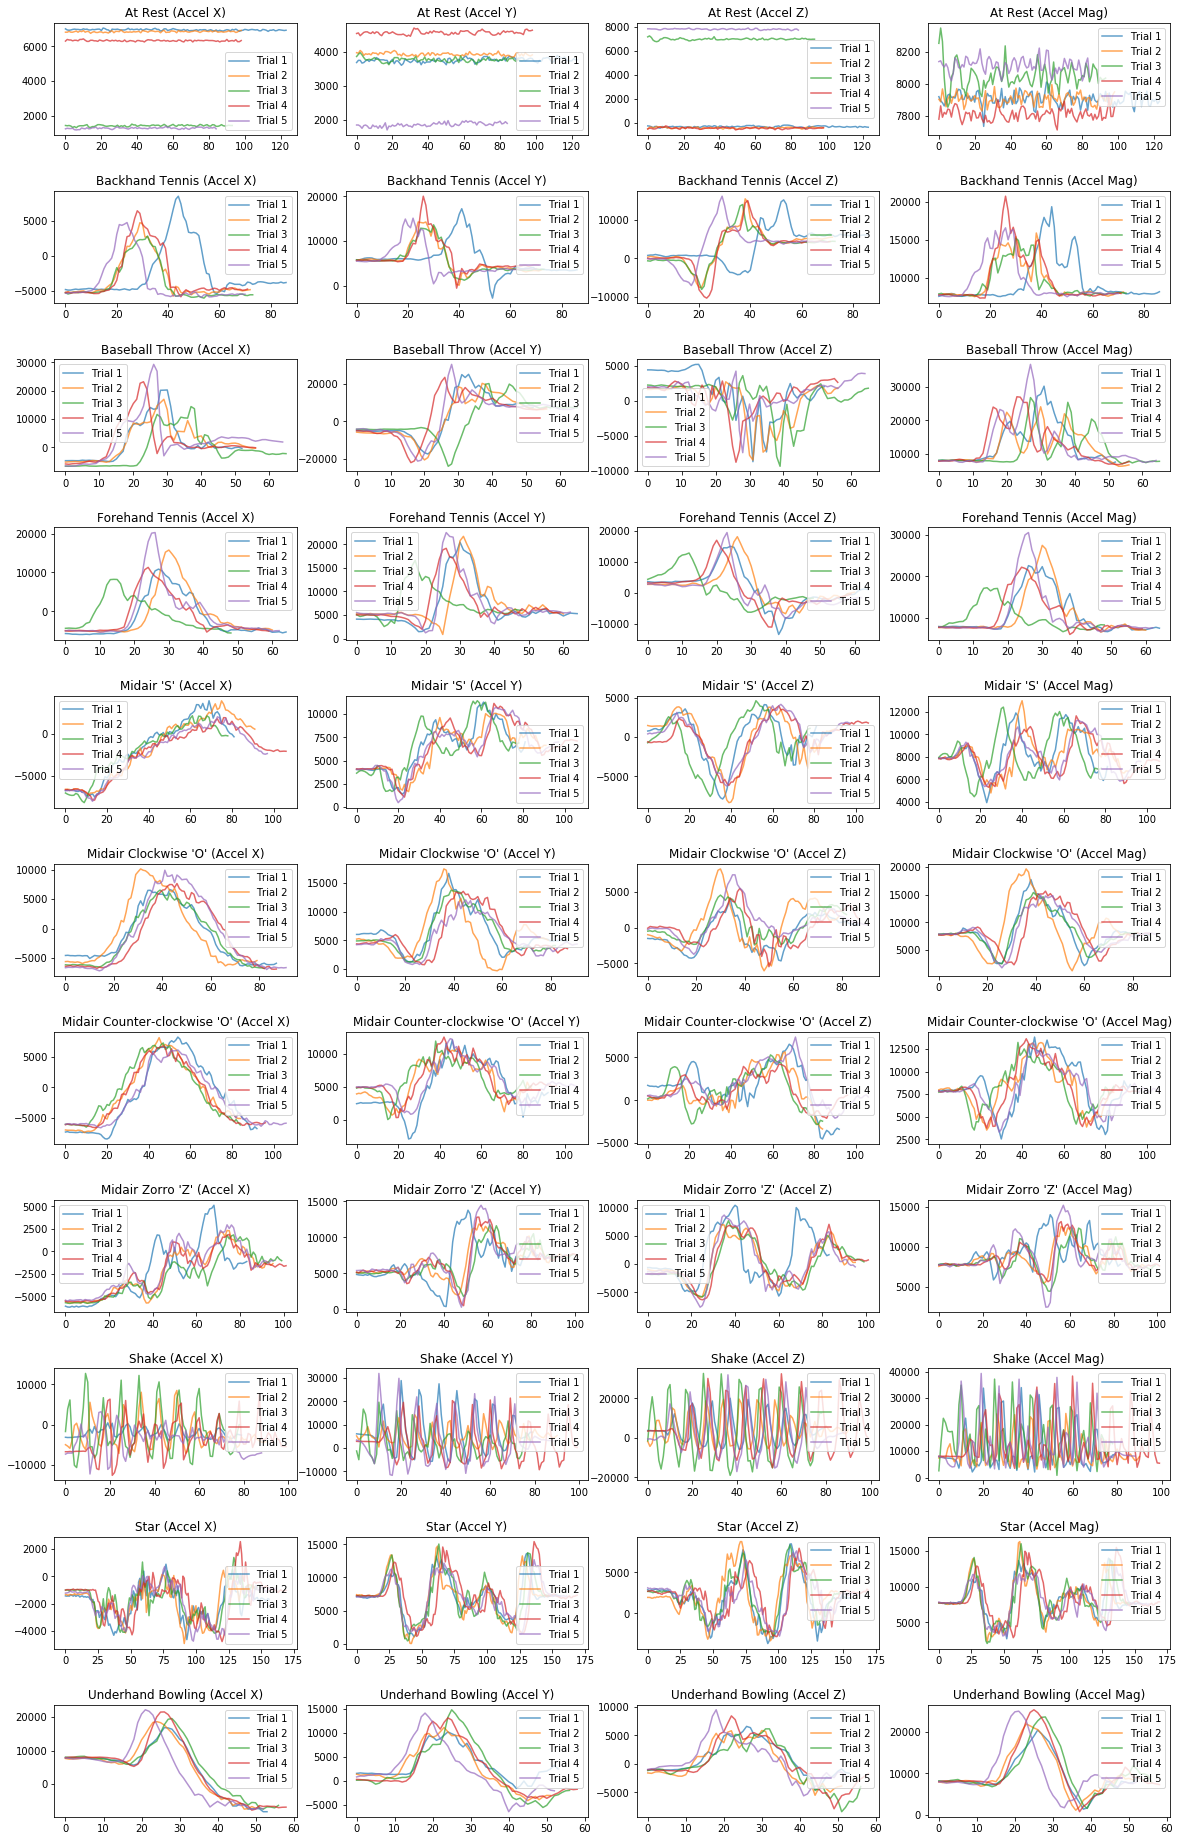

In [7]:
# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(selected_gesture_set.map_gestures_to_trials), 4, 
                         figsize=(20, 3 * len(selected_gesture_set.map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    trial_num = 1
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        trial_num = trial_num + 1
        
    axes[index][0].set_title(gesture_name + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gesture_name + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gesture_name + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gesture_name + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1

Now let's plot all of the accel signals, both raw and processed.

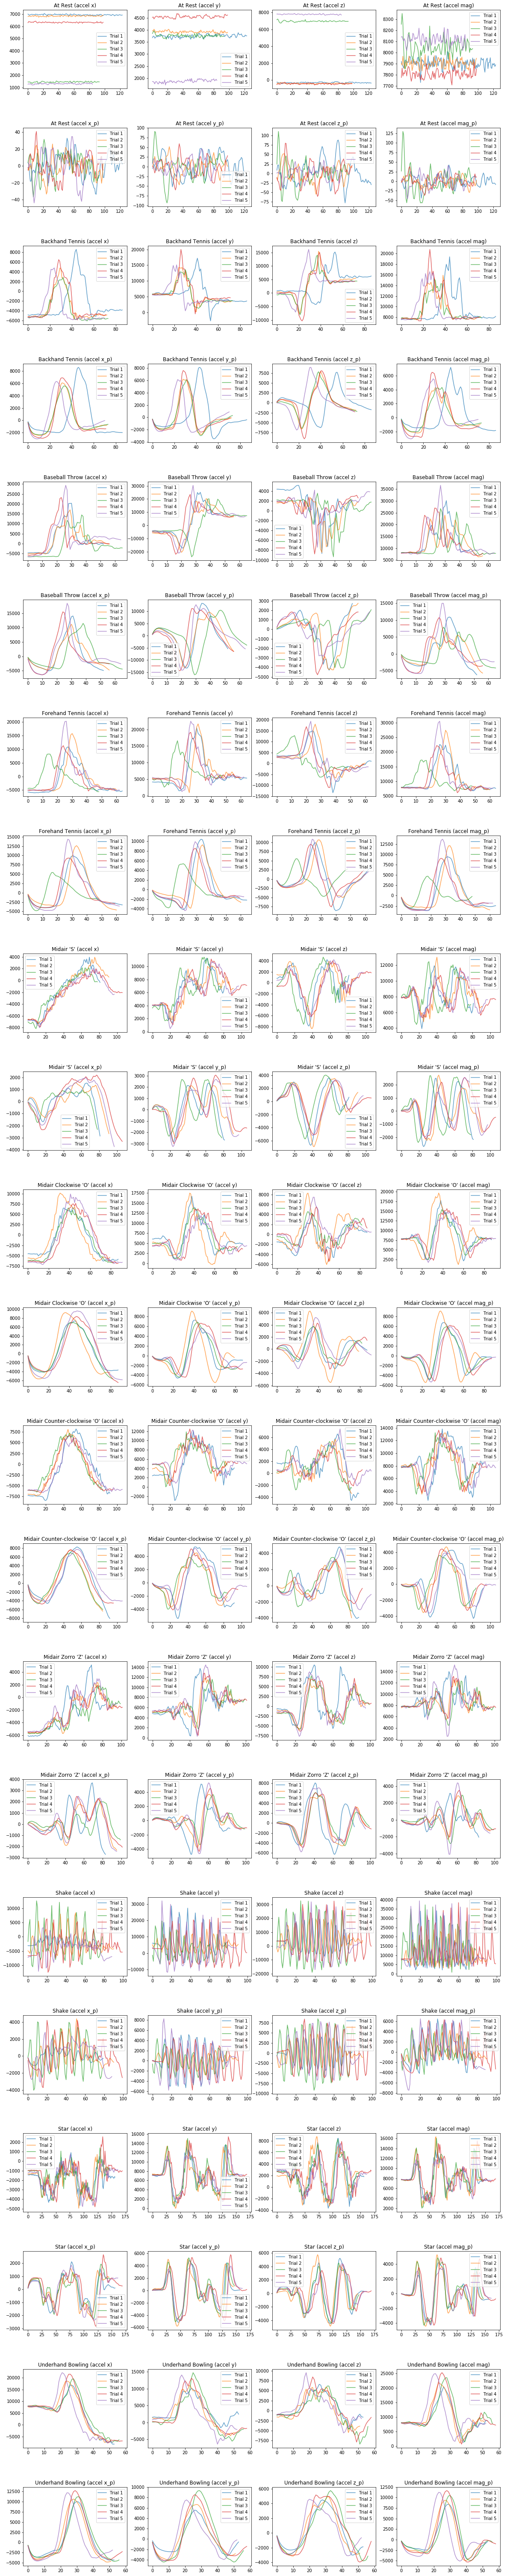

In [8]:
# We are going to make a grid of line graphs with:
# two rows for each gesture (one raw, one processed), so len(mapGestureToTrials) * 2 rows 
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(selected_gesture_set.map_gestures_to_trials) * 2, 4, 
                         figsize=(20, 5 * 2 * len(selected_gesture_set.map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    trial_num = 1
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        
        axes[index + 1][0].plot(trial.accel.x_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][1].plot(trial.accel.y_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][2].plot(trial.accel.z_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][3].plot(trial.accel.mag_p, alpha=0.7, label="Trial {}".format(trial_num))
        
        trial_num = trial_num + 1
        
    axes[index][0].set_title(gesture_name + " (accel x)")
    axes[index][1].set_title(gesture_name + " (accel y)")
    axes[index][2].set_title(gesture_name + " (accel z)")
    axes[index][3].set_title(gesture_name + " (accel mag)")
    
    axes[index][0].legend()
    axes[index][1].legend()
    axes[index][2].legend()
    axes[index][3].legend()
    
    index = index + 1
    axes[index][0].set_title(gesture_name + " (accel x_p)")
    axes[index][1].set_title(gesture_name + " (accel y_p)")
    axes[index][2].set_title(gesture_name + " (accel z_p)")
    axes[index][3].set_title(gesture_name + " (accel mag_p)")
    
    axes[index][0].legend()
    axes[index][1].legend()
    axes[index][2].legend()
    axes[index][3].legend()
    
    index = index + 1

## Plot raw vs. preprocessed magnitude
Or maybe we just want to focus on the magnitude of the signal. Is there enough visual salience in here that you think this signal alone is discriminable for classifying gestures?

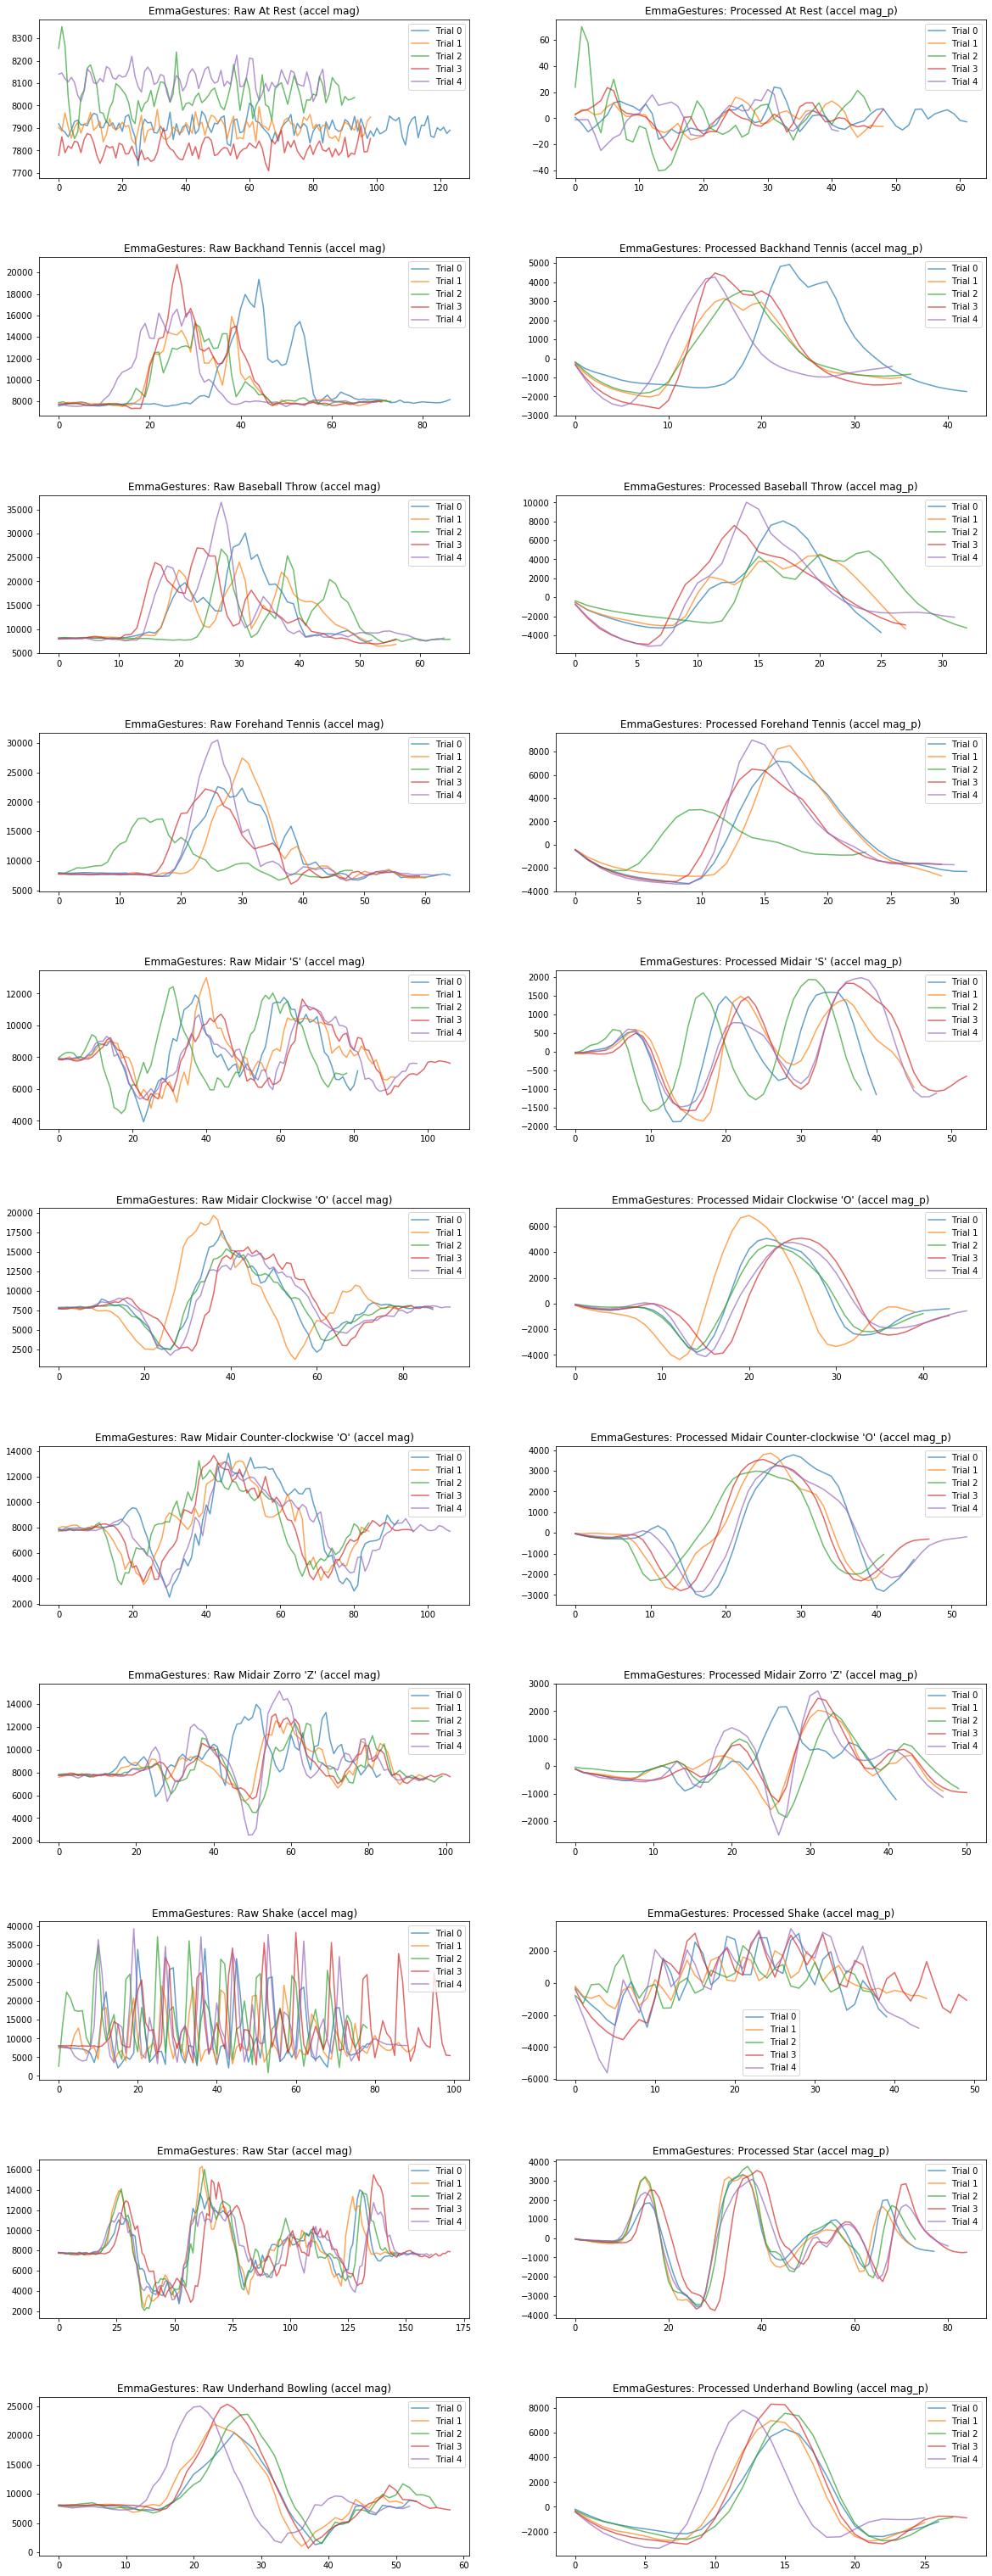

In [15]:
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 2, figsize=(20, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = map_gestures_to_trials[gesture_name]
    trial_num = 0
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.mag_p, alpha=0.7, label="Trial {}".format(trial_num))
        trial_num = trial_num + 1
        
    axes[index][0].set_title(selected_gesture_set.name + ": Raw " + gesture_name + " (accel mag)")
    axes[index][0].legend()
    
    axes[index][1].set_title(selected_gesture_set.name + ": Processed " + gesture_name + " (accel mag_p)")
    axes[index][1].legend()

    index = index + 1


# Classification experiments

Start analyzing and comparing these gesture signals.Think about:
- What patterns do you see in the data?
- What kind of filtering might be useful?
- How can you best align the signals for comparison? (e.g., hint: scroll down to see the Euclidean distance comparisons)
- What kind of signal transforms might be useful? (e.g., ffts, derivative waveforms)
- What is the simplest way we can compare two signals?


## K-Fold Cross Validation Methods

In [181]:
# The k-fold cross validation methods

def generate_kfolds(num_folds, gesture_set, seed=None):
    '''
    Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
    for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
    setting up experiments)
    
    num_folds : the number of folds
    gesture_set : the gesture set for splitting into k-folds
    seed : an integer seed value (pass in the same seed value to get the same split across multiple executions)
    '''
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        if num_folds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(num_folds, gesture_name, len(trials)))
    
    # Create dictionary with gesture name as key, array of gesture trial data as values
    gesture_dict = dict()
    for gesture_name, gesture_trials in gesture_set.map_gestures_to_trials.items():
        gesture_dict[gesture_name] = gesture_trials
            
    list_folds = []
    
    # For each gesture in the dictionary, remove a random gesture set and add it to the current fold
    for i in range(num_folds):
        curr_fold_dict = dict()
        for gesture in gesture_dict:
            rand_trial_index = random.randint(0, 4-i)
            # Get trial for gesture at random index in the gesture dictionary
            curr_fold_dict[gesture] = gesture_dict[gesture][rand_trial_index]
            # Remove that value from gesture_dict_gesture
            gesture_dict[gesture].pop(rand_trial_index)
        list_folds.append(curr_fold_dict)
    
    check_folds(list_folds) # for debugging. You can comment this out
    return list_folds # each index of the list represents a fold, which contains a map of gesture names to trials


from sklearn.model_selection import StratifiedKFold
def generate_kfolds_scikit(num_folds, gesture_set, seed=None):
    '''
    Here's an example of generating kfolds using scikit but returning our data structure
    
    Parameters:
    num_folds: the number of folds
    gesture_set: the gesture set for splitting into k-folds
    seed: an integer seed value (pass in the same seed value to get the same split across multiple executions)
    
    Returns:
    Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
    for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
    setting up experiments). Note that even with the same seed value, this method and generate_kfolds will
    generate different results.
    '''
    
    trials = []
    trial_nums = []
    gesture_names = []
    for gesture_name, gesture_trials in gesture_set.map_gestures_to_trials.items():
        for trial in gesture_trials:
            trials.append(trial)
            trial_nums.append(trial.trial_num)
            gesture_names.append(gesture_name)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    # Iterate through the splits and setup our data structure
    fold_cnt = 0
    list_folds = list()
    for train_idx, test_idx in skf.split(trials, gesture_names):
        cur_fold_map_gesture_to_trial = dict()
        for i in test_idx:
            cur_fold_map_gesture_to_trial[gesture_names[i]] = trials[i]
        list_folds.append(cur_fold_map_gesture_to_trial)    
        fold_cnt += 1
    return list_folds

def print_folds(list_folds):
    '''
    Prints out the folds (useful for debugging)
    '''
    # print out folds (for debugging)
    fold_index = 0
    if fold_index == 0:
        for fold in list_folds:
            print("Fold: ", fold_index)
            for gesture_name, trial in fold.items():
                print("\t{} Trial: {}".format(gesture_name, trial.trial_num))
            fold_index = fold_index + 1
            
def check_folds(folds):
    '''
    Checks to see that the folds are appropriately setup (useful for debugging)
    Throw an exception if there appears to be a problem
    '''
    for test_fold_idx in range(0, len(folds)):
        # check to make sure test data is not in training data
        for test_gesture, test_trial in folds[test_fold_idx].items():
            # search for this test_gesture and trial_num in all other folds
            # it shouldn't be there!
            for train_fold_idx in range(0, len(folds)):
                if test_fold_idx != train_fold_idx:
                    for train_gesture, train_trial in folds[train_fold_idx].items():
                        if test_gesture == train_gesture and test_trial.trial_num == train_trial.trial_num:
                            raise Exception("Uh oh, gesture '{}' trial '{}' was found in both test fold '{}' and\
                                             training fold '{}.' Training folds should not include test data".format(
                                            test_gesture, test_trial.trial_num, test_fold_idx, train_fold_idx))

gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Emma")

list_folds = generate_kfolds(5, gesture_set, seed=5) 

# print out folds (for debugging)
print("DEBUG: PRINTING OUT FOLDS")
print_folds(list_folds)


DEBUG: PRINTING OUT FOLDS
Fold:  0
	Shake Trial: 0
	Baseball Throw Trial: 4
	Star Trial: 0
	Midair Zorro 'Z' Trial: 2
	Midair Clockwise 'O' Trial: 4
	Midair 'S' Trial: 3
	Forehand Tennis Trial: 4
	Midair Counter-clockwise 'O' Trial: 3
	Underhand Bowling Trial: 0
	Backhand Tennis Trial: 3
	At Rest Trial: 3
Fold:  1
	Shake Trial: 3
	Baseball Throw Trial: 0
	Star Trial: 3
	Midair Zorro 'Z' Trial: 0
	Midair Clockwise 'O' Trial: 3
	Midair 'S' Trial: 4
	Forehand Tennis Trial: 3
	Midair Counter-clockwise 'O' Trial: 2
	Underhand Bowling Trial: 1
	Backhand Tennis Trial: 0
	At Rest Trial: 0
Fold:  2
	Shake Trial: 2
	Baseball Throw Trial: 1
	Star Trial: 2
	Midair Zorro 'Z' Trial: 4
	Midair Clockwise 'O' Trial: 2
	Midair 'S' Trial: 0
	Forehand Tennis Trial: 1
	Midair Counter-clockwise 'O' Trial: 4
	Underhand Bowling Trial: 2
	Backhand Tennis Trial: 1
	At Rest Trial: 4
Fold:  3
	Shake Trial: 4
	Baseball Throw Trial: 2
	Star Trial: 4
	Midair Zorro 'Z' Trial: 3
	Midair Clockwise 'O' Trial: 1
	Midair 

## The matching algorithms

We have a top-level function called `run_match_algorithm`, which takes in a list of folds (setup for k-fold cross validation) and a "pointer" to a `find_closest_match_alg` algorithm, which may take one or more arguments (from `**kwargs`). When a template trial is incorrectly matched to the test trial, this algorithm will plot the signals from both trials.

In [173]:
def run_matching_algorithm(list_folds, find_closest_match_alg, **kwargs):
    '''
    Our primary matching algorithm function that takes in a fold, a matching algorithm, and optional 
    arguments (**kwargs) for that matching alg. Returns a ClassificationResults object
    
    list_folds : the folds generated by generate_kfolds
    find_closest_match_alg : "pointer" to the closest match function you want to test
    kwargs : optional arguments to pass to find_closest_match_alg
    '''
    
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']
        
    show_incorrect_graph = False
    if 'show_incorrect' in kwargs:
        show_incorrect_graph = kwargs['show_incorrect']
    
    fold_index = 0
    map_gesture_name_to_list_results = dict()
    for fold in list_folds:
        if verbose:
            print("\n**FOLD: {}**".format(fold_index))
            
        correctness_cnt_for_fold = 0
        elapsed_time_for_fold = 0
        for test_gesture_name, test_trial in fold.items():
            template_folds = list_folds[0:fold_index] + list_folds[fold_index + 1:len(list_folds)]
            template_trials = list()
            for fold in template_folds:
                for template_gesture_name, template_trial in fold.items():
                    template_trials.append(template_trial)
            
            start_time = time.time()
            trial_classification_result = find_closest_match_alg(test_trial, template_trials, **kwargs)
            elapsed_time_in_secs = time.time() - start_time
            trial_classification_result.fold_idx = fold_index
            trial_classification_result.elapsed_time = elapsed_time_in_secs
            elapsed_time_for_fold += elapsed_time_in_secs
            
            if trial_classification_result.is_correct:
                correctness_cnt_for_fold += 1
            else: 
                if show_incorrect_graph:
                    # plot graph of test signal and incorrectly matched template signal
                    test_gesture_name = test_trial.get_ground_truth_gesture_name() # gesture that was correct

                    wrong_id_gesture = trial_classification_result.closest_trial # gesture incorrectly ID'd as correct
                    wrong_id_gesture_name = wrong_id_gesture.gesture_name

                    matching_alg_name = ''
                    if 'match_alg_title' in kwargs:
                        matching_alg_name = kwargs['match_alg_title'] + " "

                    fig, axes = plt.subplots(1, figsize=(20, 5)) #figsize is width, height
                    axes.plot(test_trial.accel.mag, alpha=0.7, label="Test trial (" + test_gesture_name + ")")
                    axes.plot(wrong_id_gesture.accel.mag, alpha=0.7, label="Misidentified template trial (" + wrong_id_gesture_name + ")")
                    axes.set_title(selected_gesture_set.name + ": " + matching_alg_name + test_gesture_name + " misidentified as " + wrong_id_gesture_name)
                    axes.legend()

            if verbose:
                print(trial_classification_result)
            
            # track overall results across comparisons
            if test_gesture_name not in map_gesture_name_to_list_results:
                map_gesture_name_to_list_results[test_gesture_name] = list()
            map_gesture_name_to_list_results[test_gesture_name].append(trial_classification_result)
            
        # print out overall fold accuracy
        fold_accuracy = (correctness_cnt_for_fold / len(fold)) * 100;
        if verbose:
            print("COMPLETED FOLD: {} IN {:0.3f} SECS WITH ACCURACY {}/{} ({:0.1f}%)".
                  format(fold_index, elapsed_time_for_fold, correctness_cnt_for_fold, len(fold), fold_accuracy))

        fold_index = fold_index + 1
    
    classification_result = ClassificationResults(find_closest_match_alg.__name__, 
                                                  map_gesture_name_to_list_results, **kwargs)
    return classification_result
            

### Write your matching algorithms here

We've created two simple matching functions to help you understand the format for our experimental testbed.

In [179]:
def find_closest_match_euclid_raw_x(test_trial, template_trials, **kwargs):
    '''
    Example closest match function using euclidean distance and the accelerometer X value
    Note: I'm not saying this is necessarily a *good performing* example but it should run :)
    
    For a more generic version of this method, see find_closest_match_euclid_signal
    
    Example:
    run_matching_algorithm(list_folds, find_closest_match_euclid_raw_x, verbose=True)
    
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: optional arguments for match function
    
    Returns a TrialClassificationResult
    '''
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # Euclidean distance requires that both arrays are the same length, so we must pad the shorter one
        test_trial_signal = test_trial.accel.x
        template_trial_signal = template_trial.accel.x
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        euclid_distance = distance.euclidean(test_trial_signal, template_trial_signal)
        n_best_list_tuple.append((template_trial, euclid_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result


def find_closest_match_euclid_signal(test_trial, template_trials, **kwargs):
    '''
    Example closest match function using euclidean distance and a specified
    signal from SensorData (e.g., x, y, z, mag, x_p, y_p, z_p, mag_p)
    
    This is exactly the same as find_closest_match_euclid_raw_x but more flexible
    in that you can pass a member variable of SensorData in signal_var_name
    
    Example:
    run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='x')
    run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='y')
    
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: one required argument for match function
        signal_var_name must be specified and is the member variable of SensorData used for 
        the test (e.g., x, y, z, mag, x_p, y_p, z_p, mag_p )
    
    Returns a TrialClassificationResult
    '''
    
    if 'signal_var_name' not in kwargs:
        raise Exception("The 'signal_var_name' kwarg must be specified. For example, \"signal_var_name='x'\"") 
   
    signal_var_name = kwargs['signal_var_name']
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # Euclidean distance requires that both arrays are the same length, so we must pad the shorter one
        test_trial_signal = getattr(test_trial.accel, signal_var_name)
        template_trial_signal = getattr(template_trial.accel, signal_var_name)
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        euclid_distance = distance.euclidean(test_trial_signal, template_trial_signal)

        n_best_list_tuple.append((template_trial, euclid_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result


def find_closest_match_fastdtw(test_trial, template_trials, **kwargs):
    '''
    Closest match function using fastdtw library. Takes the absolute value of dtw distance
    along all accelerometer dimensions
    
    Example:
    run_matching_algorithm(list_folds, find_closest_match_fastdtw, verbose=True)
    
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: optional arguments for match function
    
    Returns a TrialClassificationResult
    '''
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # Get signal for each accel dimension
        test_x = getattr(test_trial.accel, 'x')
        template_x = getattr(template_trial.accel, 'x')
        
        test_y = getattr(test_trial.accel, 'y')
        template_y = getattr(template_trial.accel, 'y')
        
        test_z = getattr(test_trial.accel, 'z')
        template_z = getattr(template_trial.accel, 'z')
        
        test_mag = getattr(test_trial.accel, 'mag')
        template_mag = getattr(template_trial.accel, 'mag')
        
        # Run fastdtw on each dimension
        dtw_x = fastdtw(test_x, template_x, dist=None)
        dtw_y = fastdtw(test_y, template_y, dist=None)
        dtw_z = fastdtw(test_z, template_z, dist=None)
        dtw_mag = fastdtw(test_mag, template_mag, dist=None)

        # Take absolute value of each DTW distance
        dtw_distance = math.sqrt(math.pow(dtw_x[0], 2) + math.pow(dtw_y[0], 2) + math.pow(dtw_z[0], 2) + math.pow(dtw_mag[0], 2))

        n_best_list_tuple.append((template_trial, dtw_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result


def find_closest_match_dtw(test_trial, template_trials, **kwargs):
    '''
    Closest match function with manual DTW implementation. Runs DTW on one dimension of 
    accelerometer signal.
    
    Example:
    run_matching_algorithm(list_folds, find_closest_match_dtw, verbose=True, signal_var_name='y')
    
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: optional arguments for match function
    
    Returns a TrialClassificationResult
    '''
    if 'signal_var_name' not in kwargs:
        raise Exception("The 'signal_var_name' kwarg must be specified. For example, \"signal_var_name='x'\"") 
   
    signal_var_name = kwargs['signal_var_name']
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        test_trial_signal = getattr(test_trial.accel, signal_var_name)
        template_trial_signal = getattr(template_trial.accel, signal_var_name)
        
        dtw_distance = compute_dtw(test_trial_signal, template_trial_signal)

        n_best_list_tuple.append((template_trial, dtw_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result


def compute_dtw(test, template):
    '''
    Compute DTW distance between two signals
    
    Example:
    compute_dtw(test_trial_signal, template_trial_signal)
    
    Parameters:
    test: the test signal
    template: the template signal
    
    Returns a distance
    '''
    dtw = [[0 for i in range(len(template))] for j in range(len(test))]

    # Populate distance matrix with infinity values
    for test_index in range(len(test)):
        for template_index in range(len(template)):
            dtw[test_index][template_index] = float("inf")
            
    dtw[0][0] = 0
    
    # Calculate shortest distance for each combination of points in the matrix
    for test_index in range(1, len(test)):
        for template_index in range(1, len(template)):
            cost = abs(test[test_index] - template[template_index])
            dtw[test_index][template_index] = cost + min(dtw[test_index-1][template_index], dtw[test_index][template_index-1], dtw[test_index-1][template_index-1])
    
    # Return shortest distance between signals
    return dtw[len(test)-1][len(template)-1]
    
    
def find_closest_match_scale(test_trial, template_trials, **kwargs):
    '''
    Closest match function that standardizes both signals. Mostly implemented as an idea that never
    panned out. Overall accuracy is low compared to other approaches.
    
    Example:
    run_matching_algorithm(list_folds, find_closest_match_scale, verbose=True, signal_var_name='y')
    
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: optional arguments for match function
    
    Returns a TrialClassificationResult
    '''
        
    if 'signal_var_name' not in kwargs:
        raise Exception("The 'signal_var_name' kwarg must be specified. For example, \"signal_var_name='x'\"") 
   
    signal_var_name = kwargs['signal_var_name']
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        test_trial_signal = getattr(test_trial.accel, signal_var_name)
        template_trial_signal = getattr(template_trial.accel, signal_var_name)
        
        # Euclidean distance requires that both arrays are the same length, so we must pad the shorter one
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')

        # Standardize both signals
        scaled_template = preprocessing.scale(template_trial_signal)
        scaled_test = preprocessing.scale(test_trial_signal)
        
        # Calculate the Euclidean distance between the two standardized signals
        scaled_euclid_distance = distance.euclidean(scaled_test, scaled_template)

        n_best_list_tuple.append((template_trial, scaled_euclid_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result


def find_closest_match_correlate(test_trial, template_trials, **kwargs):
    '''
    Closest match function using cross correlation. Takes the absolute value
    of cross correlation along each accelerometer signal dimension.
    
    Example:
    run_matching_algorithm(list_folds, find_closest_match_correlate)
    
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: optional arguments for match function
    
    Returns a TrialClassificationResult
    '''
        
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # Get signal for each accel dimension
        test_x = getattr(test_trial.accel, 'x')
        template_x = getattr(template_trial.accel, 'x')
        
        test_y = getattr(test_trial.accel, 'y')
        template_y = getattr(template_trial.accel, 'y')
        
        test_z = getattr(test_trial.accel, 'z')
        template_z = getattr(template_trial.accel, 'z')
        
        test_mag = getattr(test_trial.accel, 'mag')
        template_mag = getattr(template_trial.accel, 'mag')
        
        # Run correlation on each dimension for a given accel signal
        correlate_x = correlate_signals(test_x, template_x)
        correlate_y = correlate_signals(test_y, template_y)
        correlate_z = correlate_signals(test_z, template_z)
        correlate_mag = correlate_signals(test_mag, template_mag)

        # Get absolute value of each correlation distance
        correlate_distance = math.sqrt(math.pow(correlate_x, 2) + math.pow(correlate_y, 2) + math.pow(correlate_z, 2) + math.pow(correlate_mag, 2))

        n_best_list_tuple.append((template_trial, correlate_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result


def correlate_signals(a, b, pad_function = None):
    '''
    Aligns signals using cross correlation. Code sourced from correlation section of the Jupyter Notebook
    found at https://github.com/makeabilitylab/signals/blob/master/Tutorials/Signals%20-%20Comparing%20Signals.ipynb
    '''
    
    # Pad the shorter signal with its mean value.
    if(len(a) != len(b)):
        if(len(a) < len(b)):
            a = np.pad(a, (0, len(b) - len(a)), mode='mean')
        else:
            b = np.pad(b, (0, len(a) - len(b)), mode='mean')
    
    # Correlate and calculate signal shifts
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))
    
    # Calculate euclidean distance between the signals
    euclid_distance_a_to_b = distance.euclidean(a, b)
    
    # Determine signal shift
    best_correlation_index = np.argmax(correlate_result)
    shift_amount = (-len(a) + 1) + best_correlation_index
    
    # Calculate euclidean distance between shifted signal and test signal
    b_shifted_mean_fill = makelab.signal.shift_array(b, shift_amount, np.mean(b))
    euclid_distance_a_to_b_shifted_mean_fill = distance.euclidean(a, b_shifted_mean_fill)
    
    return euclid_distance_a_to_b_shifted_mean_fill

## Running Experiments

In [175]:
# Run experiments
# Note: remember, we want you to write your own generate_kfolds function
# You can use generate_kfolds_scikit instead if you'd like to test other parts of your code 
# but you must eventually write your own kfold split code for the assignment
gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Emma")

list_folds = generate_kfolds(5, gesture_set, seed=5) 

# track multiple experiments
experiments = Experiments()


# run Euclidean experiments

# results_x = run_matching_algorithm(list_folds, find_closest_match_euclid_raw_x, verbose=True, match_alg_title="Euclid x")
# results_x.title = "{}: Euclidean distance with raw x signal".format(gesture_set.name)
# experiments.add(results_x)

# results_y = run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='y', match_alg_title="Euclid y")
# results_y.title = "{}: Euclidean distance with raw y signal".format(gesture_set.name)
# experiments.add(results_y)

# results_y = run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='z', match_alg_title="Euclid z")
# results_y.title = "{}: Euclidean distance with raw z signal".format(gesture_set.name)
# experiments.add(results_y)

# results_mag = run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=True, signal_var_name='mag', match_alg_title="Euclid mag")
# results_mag.title = "{}: Euclidean distance with raw mag signal".format(gesture_set.name)
# experiments.add(results_mag)


# run correlation experiment

# results_correlate = run_matching_algorithm(list_folds, find_closest_match_correlate, verbose=False, match_alg_title="Correlate")
# results_correlate.title = "{}: Correlate with absolute values".format(gesture_set.name)
# results_correlate.print_result()

# experiments.add(results_correlate)


# run scaling standardization experiment

# results_scale = run_matching_algorithm(list_folds, find_closest_match_scale, verbose=False, signal_var_name='z', match_alg_title="Scale z")
# results_scale.title = "{}: Scale with raw z signal".format(gesture_set.name)
# results_scale.print_result()

# experiments.add(results_scale)


# run DTW experiments

results_dtw = run_matching_algorithm(list_folds, find_closest_match_fastdtw, verbose=False, match_alg_title="Fast DTW")
results_dtw.title = "{}: Fast DTW".format(gesture_set.name)
results_dtw.print_result()

experiments.add(results_dtw)

# results_manual_dtw = run_matching_algorithm(list_folds, find_closest_match_dtw, verbose=False, signal_var_name='y', match_alg_title="Manual DTW y")
# results_manual_dtw.title = "{}: Manual DTW with raw y signal".format(gesture_set.name)
# results_manual_dtw.print_result()

# experiments.add(results_manual_dtw)


/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In futu


Title: EmmaGestures: Fast DTW: 55/55 (100.00%)
Optional arguments: {'verbose': False, 'match_alg_title': 'Fast DTW'}
Took 2.667s for 55 comparisons (avg=0.048s per match)
- At Rest 5/5 (100.0%)
- Backhand Tennis 5/5 (100.0%)
- Baseball Throw 5/5 (100.0%)
- Forehand Tennis 5/5 (100.0%)
- Midair 'S' 5/5 (100.0%)
- Midair Clockwise 'O' 5/5 (100.0%)
- Midair Counter-clockwise 'O' 5/5 (100.0%)
- Midair Zorro 'Z' 5/5 (100.0%)
- Shake 5/5 (100.0%)
- Star 5/5 (100.0%)
- Underhand Bowling 5/5 (100.0%)
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 5]]


# Visualizing Experiment Results
We've written a number of functions to help visualize experimental results.

In [176]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.lines import Line2D

def plot_bar_graph_average_scores_by_gesture(classification_results):
    '''
    Plots the average scores for correct and incorrect matches
    A good matching algorithm should have much lower scores for correct
    matches than incorrect matches (if this is not the case, you'll want to work
    on improving your matching algorithm)
    '''
  
    correct_score_means = []
    incorrect_score_means = []
    gesture_names = classification_results.get_gesture_names()
    for gesture_name in gesture_names:
        scores_correct_matches = np.array(classification_results.get_correct_match_scores_for_gesture(gesture_name))
        scores_incorrect_matches = np.array(classification_results.get_incorrect_match_scores_for_gesture(gesture_name))

        if len(scores_correct_matches) > 0:
            correct_score_means.append(np.mean(scores_correct_matches))
        else:
            correct_score_means.append(0)
        
        if len(scores_incorrect_matches) > 0:
            incorrect_score_means.append(np.mean(scores_incorrect_matches))
        else:
            incorrect_score_means.append(0)

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, correct_score_means, bar_width, alpha=opacity, color='b', label='Correct')
    bars_incorrect = plt.bar(index + bar_width, incorrect_score_means, bar_width, alpha=opacity, color='g', label='Incorrect')

    plt.xlabel('Gesture')
    plt.ylabel('Average Scores')
    plt.title('Average Scores By Gesture and Correctness\n' + classification_results.get_title())
    plt.xticks(index - bar_width, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_average_nbestlist_location_by_gesture(classification_results):
    '''
    Plots the average n-best list location for each gesture
    '''
    avg_nbestlist_location = []
    gesture_names = classification_results.get_gesture_names()

    for gesture_name in gesture_names:
        correct_match_indices_in_nbestlist = np.array(classification_results.get_correct_match_indices_in_nbestlist_for_gesture(gesture_name))
        avg_nbestlist_location.append(np.mean(correct_match_indices_in_nbestlist))

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    # bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, avg_nbestlist_location, alpha=opacity, color='b', label='Avg NBest List Location')

    plt.xlabel('Gesture')
    plt.ylabel('Average NBest List Location')
    plt.title('Average NBest List Location By Gesture\n' + classification_results.get_title())
    plt.xticks(index, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_classification_result_as_confusion_matrix(classification_result, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Code based on:
      - http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    See also
      - https://stackoverflow.com/a/35572520
      - Plotting with matshow: https://matplotlib.org/gallery/images_contours_and_fields/matshow.html#sphx-glr-gallery-images-contours-and-fields-matshow-py
    """
    cm = classification_result.get_confusion_matrix()
    classes = classification_result.get_gesture_names()
    plot_confusion_matrix(cm, classes, classification_result.get_title(), normalize, cmap)
    
def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")

    # print(cm)
    plt.figure(figsize=(12, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #imshow displays data on a 2D raster
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_bar_graph_overall_performance(experiments):
    '''
    Plots a bar graph of overall performance
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_accuracy();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_accuracies = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_accuracies.append(experiment.get_accuracy())

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_accuracies, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_accuracies):
        ax.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Overall Accuracy')
    plt.xlim(0, 1.2)
    plt.title('Overall Accuracy by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_overall_time(experiments):
    '''
    Plots a bar graph of overall computation time per experiment
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_computation_time();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_times = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_times.append(experiment.total_time)

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_times, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_times):
        ax.text(v, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Overall Time (secs)')
    plt.xlim(0, list_experiments[-1].total_time * 1.3)
    plt.title('Overall Time (Secs) by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_avg_time_per_comparison(experiments):
    '''
    Plots a bar graph of average computation time per comparison for each experiment
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_avg_time_per_comparison();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_times = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_times.append(experiment.get_avg_time_per_comparison())

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_times, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_times):
        ax.text(v, i, "{:0.4f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Average Time per Comparison (secs)')
    plt.xlim(0, list_experiments[-1].get_avg_time_per_comparison() * 1.2)
    plt.title('Average Time per Comparison (Secs) by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_nbestlist_performance(experiments):
    '''
    Plots a line graph of n-best list performance
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_accuracy();
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    marker = itertools.cycle(('.','o','v','^','<','>','8',
                              's','p','P','*','h','H','+','x','X','D','d','|',
                              '_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',')) 
    
    for experiment in list_experiments:
        nbest_list_performance = experiment.get_nbestlist_performance()
        axes.plot(nbest_list_performance, marker=next(marker), label=experiment.title)
    
    axes.grid()
    axes.legend()
    axes.set_title("Accuracy as a Function of N-Best List Position")
    axes.set_ylabel("Accuracy (%)")
    axes.set_ylim(0, 1.1)
    axes.set_xlabel("N-Best List Position")

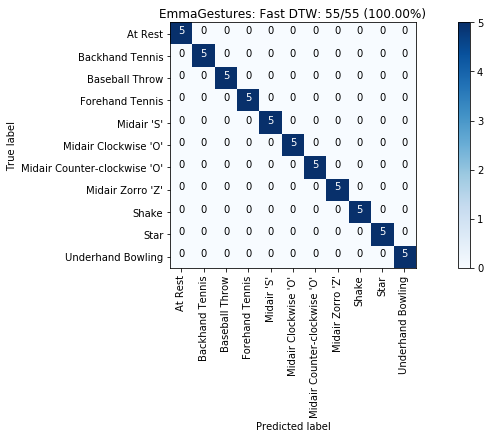

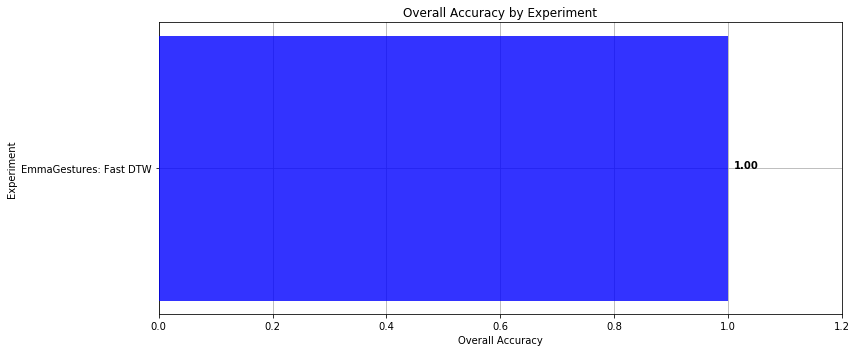

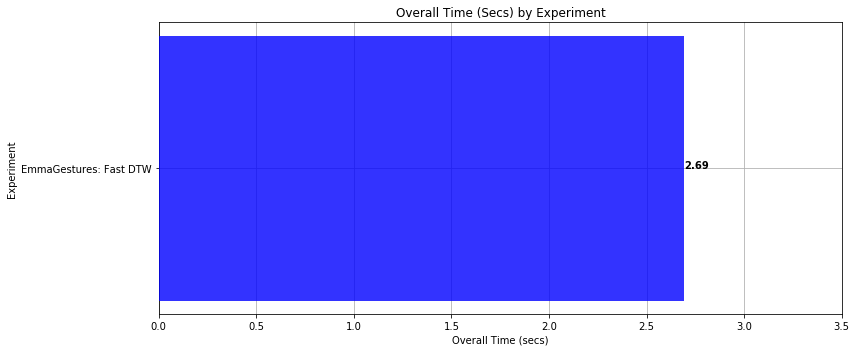

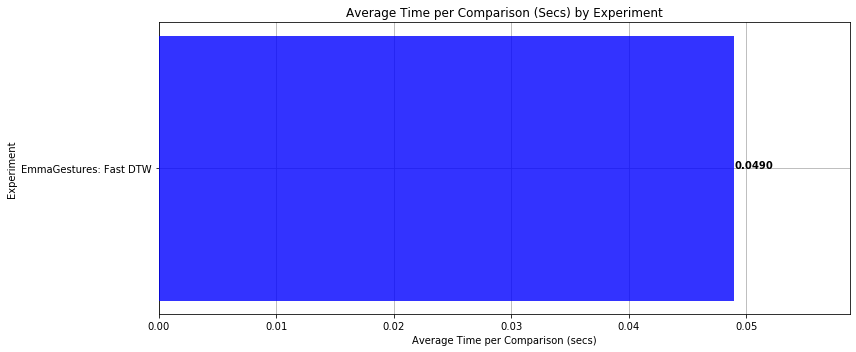

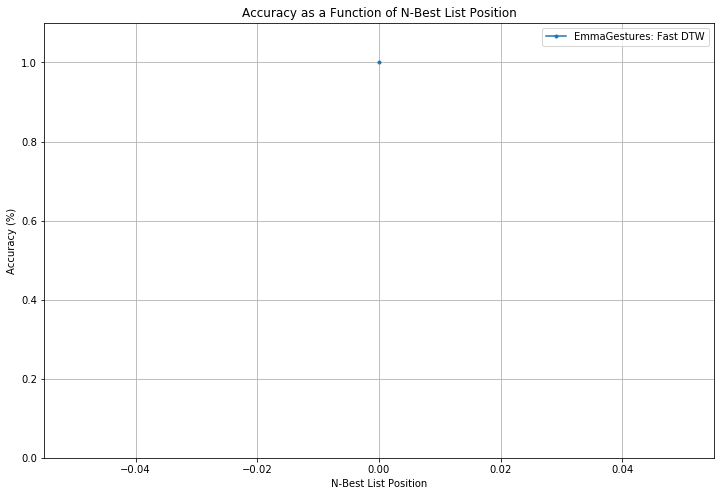

In [171]:
plot_classification_result_as_confusion_matrix(results_dtw)
plot_bar_graph_overall_performance(experiments)
plot_bar_graph_overall_time(experiments)
plot_bar_graph_avg_time_per_comparison(experiments)
plot_nbestlist_performance(experiments)


# Comparing performance across gesture sets

/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In futu

/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In futu

/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In futu

/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
/Users/emeersman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In futu

Average accuracy: 0.974825174825175 Stdev=0.053623187448058225


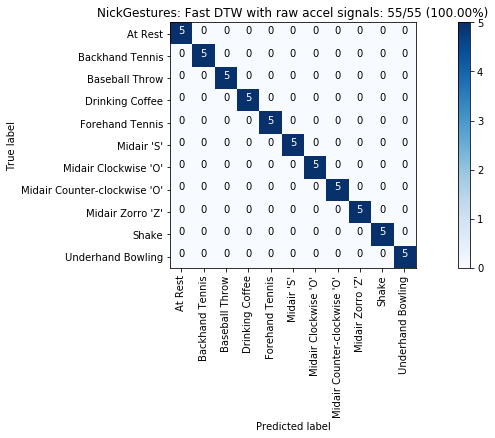

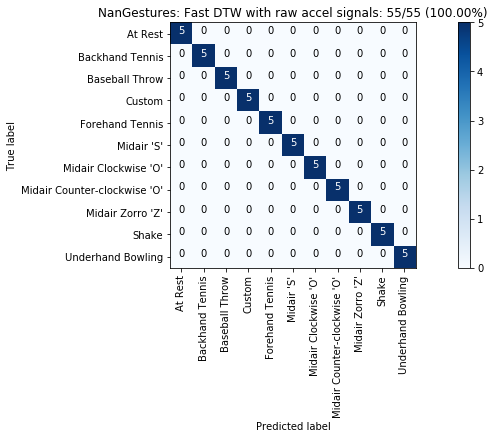

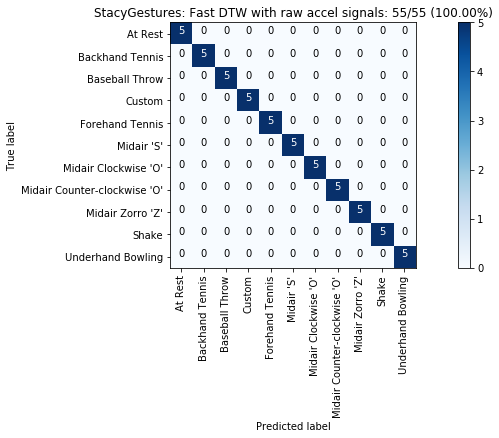

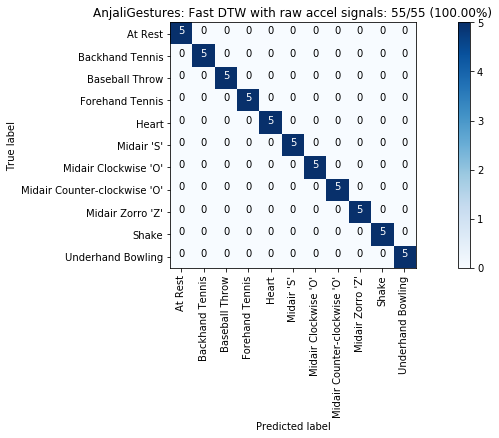

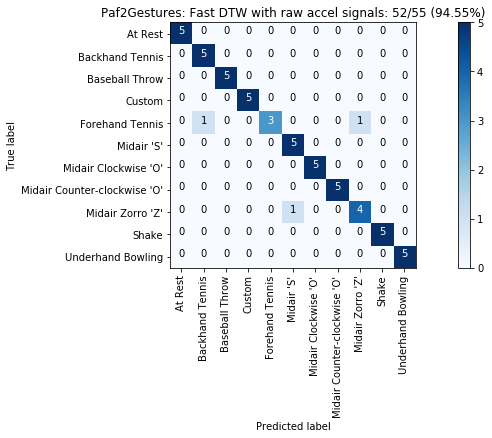

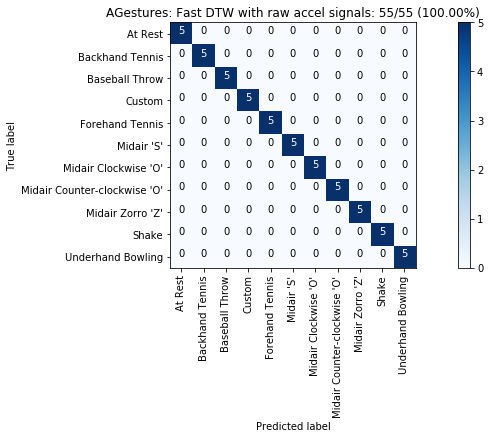

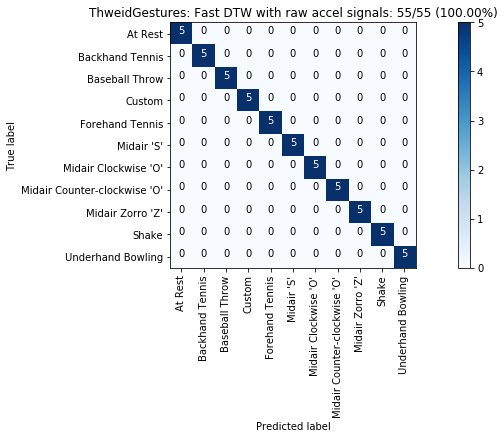

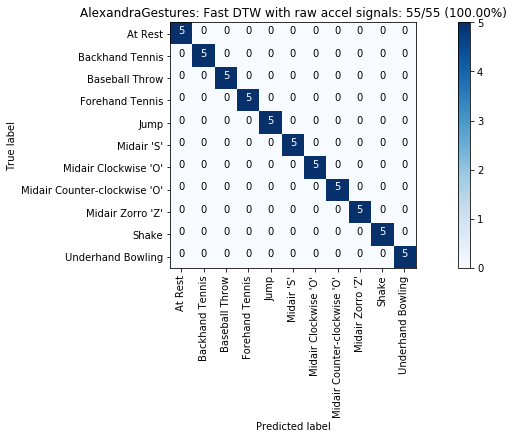

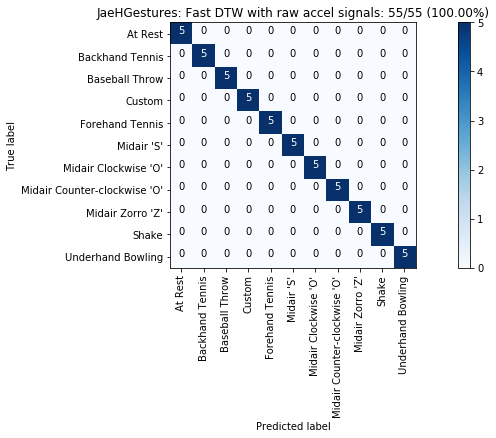

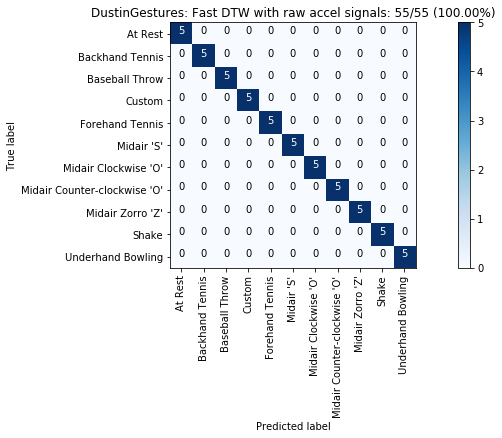

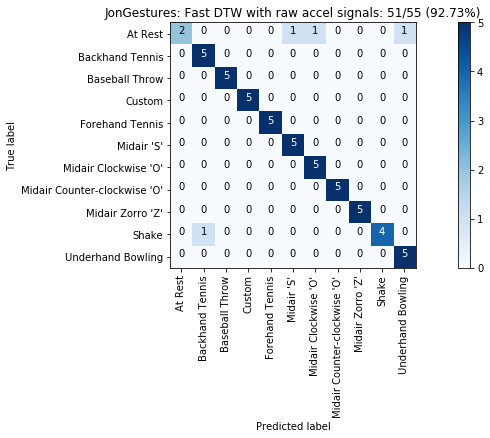

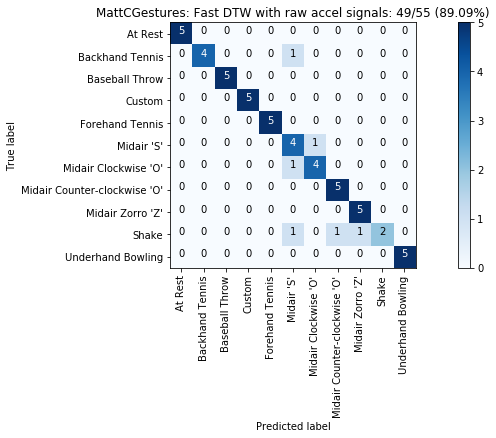

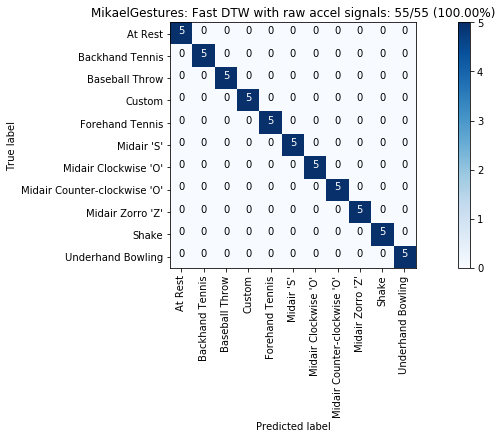

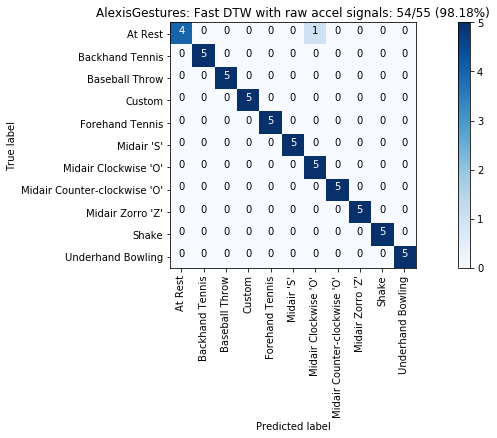

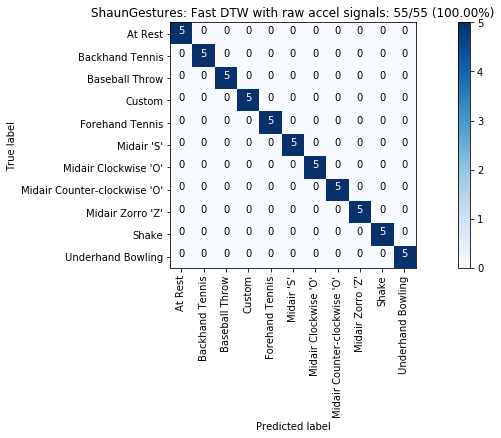

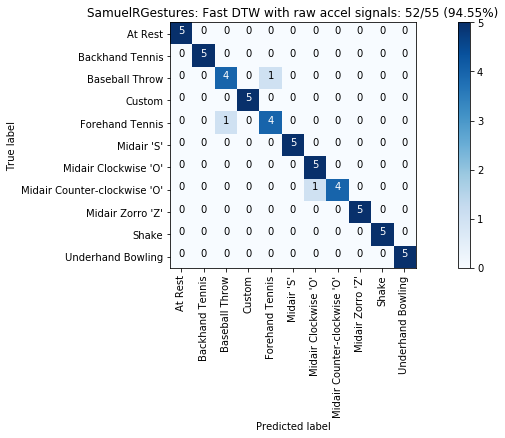

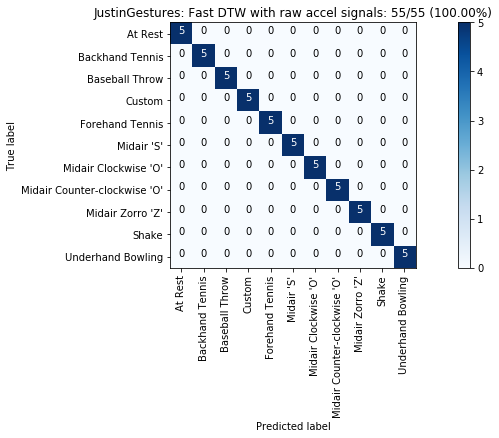

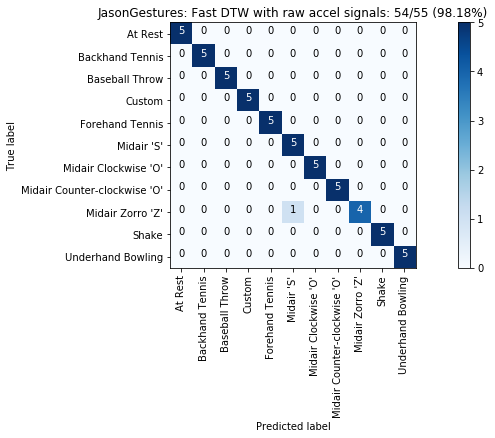

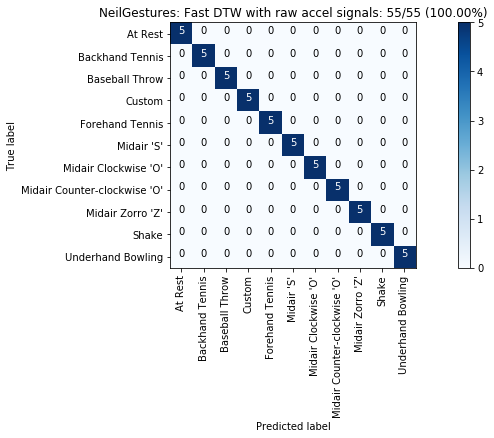

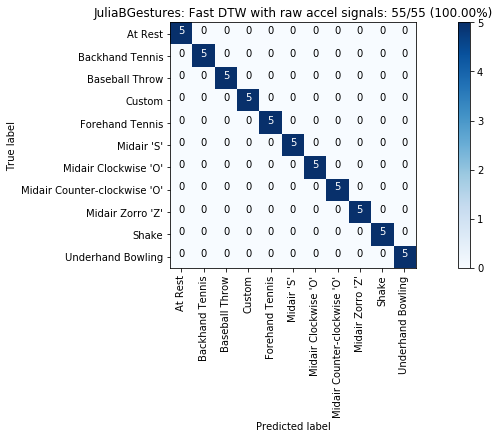

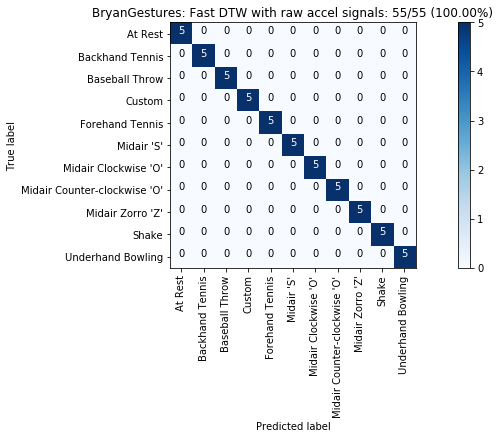

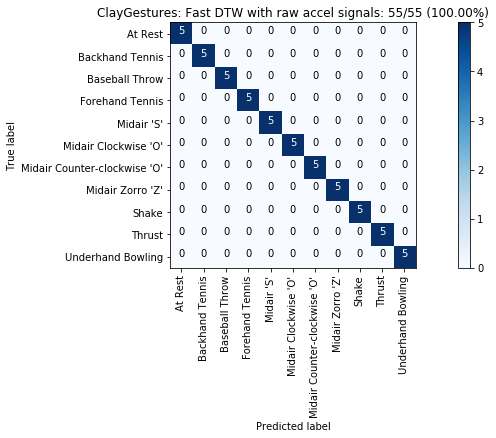

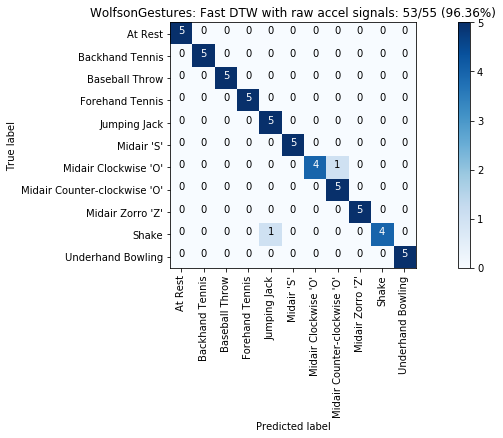

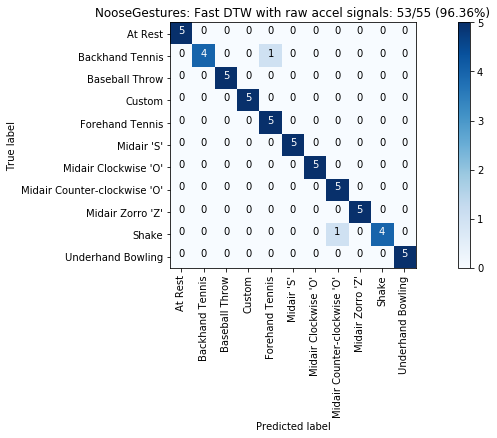

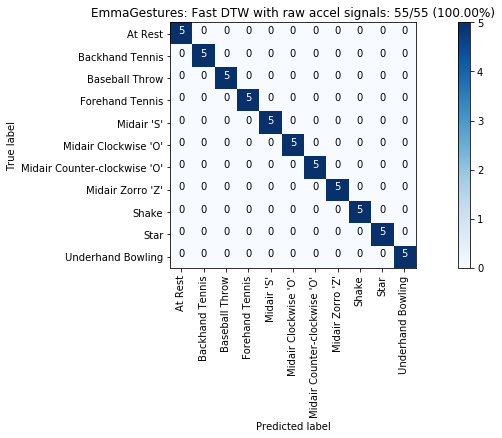

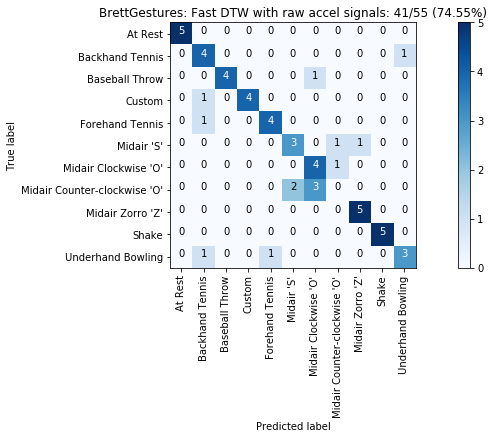

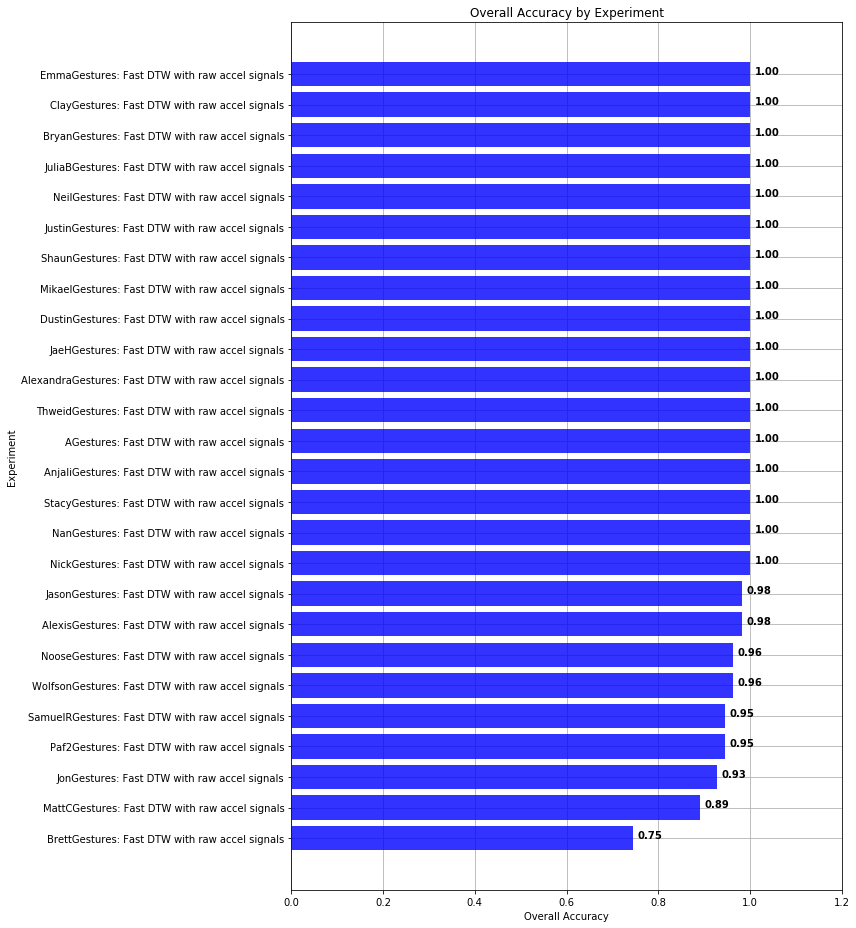

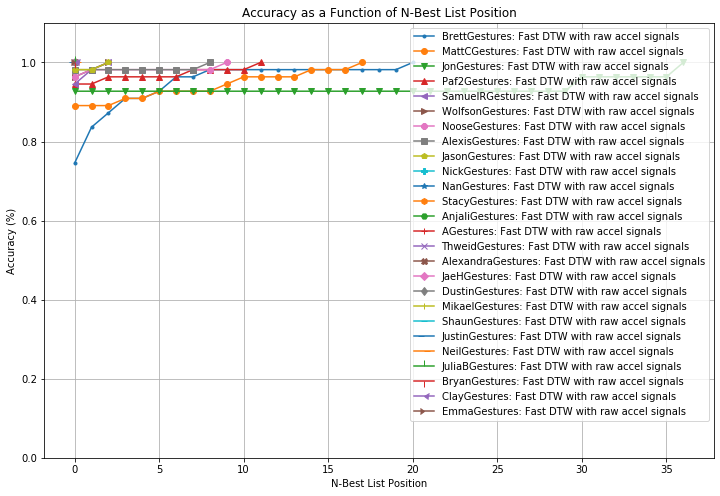

In [177]:
# track multiple experiments
experiments = Experiments()

# Run experiments across all gesture sets
for gesture_set_name, gesture_set in map_gesture_sets.items():
   
    list_folds = generate_kfolds_scikit(5, gesture_set, seed=5)
    
    # run fast DTW experiment
    results = run_matching_algorithm(list_folds, find_closest_match_fastdtw, verbose=False)
    results.title = "{title}: Fast DTW with raw accel signals".format(title=gesture_set.name)
    
    plot_classification_result_as_confusion_matrix(results)
    experiments.add(results)

avg_accuracy, stddev = experiments.get_avg_accuracy_with_std()
print(f"Average accuracy: {avg_accuracy} Stdev={stddev}")
plot_bar_graph_overall_performance(experiments)
plot_nbestlist_performance(experiments)

In [178]:
avg_accuracy, stddev = experiments.get_avg_accuracy_with_std()
print(f"Average accuracy: {avg_accuracy} Stdev={stddev}")

Average accuracy: 0.974825174825175 Stdev=0.053623187448058225


# Sandbox
Everything below here is a Sandbox for you to play. You could do this in another Jupyter Notebook but I often have some cells at the bottom of my notebook that let's me experiment with and play with Python and the numpy, scipy, etc. libraries. I've added some example playground cells that I used when making the assignment.

Feel free to delete all of these cells but I thought they might be informative for you.

In [19]:
# Demonstration of numpy arithmetic array operations
import numpy as np
x = np.array([1,2,3])
y = np.array([1,2,3])
z = np.array([1,2,3])

sum1 = np.add(x, y, z)
print(sum1)

x = np.array([1,2,3])
y = np.array([1,2,3])
z = np.array([1,2,3])

sum2 = x + y + z
print(sum2)

[2 4 6]
[3 6 9]


In [20]:
# playing around with numpy subtraction. In order for these operations to work
# the arrays must be of the same size
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([1, 2, 4, 5, 5])
np2 - np1

np3 = [1, 2, 3]

# the (0,2) value tells pad to pad 0 times in the front of array
# and three times to the end of array. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
np3_resized = np.pad(np3, (0, 2), 'constant', constant_values=0)
np3_resized - np2

array([ 0,  0, -1, -5, -5])

In [21]:
# Testing to see if the numpy 'where' method supports string matching
a = np.array(['apple', 'orange', 'apple', 'banana'])

indicesWhereThereAreApples = np.where(a == 'apple')

print (indicesWhereThereAreApples)
print (a[indicesWhereThereAreApples])

(array([0, 2], dtype=int64),)
['apple' 'apple']


In [22]:
# Playing around with classes in Python 3. Notice how just like in Javascript, you can add a new member variable
# just by starting to use it!

class DummyClass:
    def __init__(self, variable):
        self.testVar = variable
        

dummy = DummyClass(5)
print(dummy.testVar)
dummy.newVar = 7 # added a new member variable called newVar here. Cool!
print(dummy.newVar)
vars(dummy) # prints out the member variables of the class

5
7


{'testVar': 5, 'newVar': 7}

In [23]:
# Experimenting with how unpacking tuples work
testTuple = (1,2,3,4,5,6,7,8,9,10)
print(testTuple)
print(*testTuple)
print(*testTuple[5:])

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
1 2 3 4 5 6 7 8 9 10
6 7 8 9 10


In [24]:
# Experimenting with how we delete things out of lists
import random
testDict = {"a":1, "c":3, "d":4}
a = list(testDict.keys())
print(a)
random.shuffle(a)
print(a)
del a[1]
print(a)

['a', 'c', 'd']
['a', 'c', 'd']
['a', 'd']


In [25]:
# Playing around with how we can split up and combine lists in Python
testList = [1, 2, 3, 4, 5]
index = 4
print(testList[0:index] + testList[index + 1:5])

index = 3
print(testList[0:index] + testList[index + 1:5])

print(testList[index:])
print(testList[:index])

[1, 2, 3, 4]
[1, 2, 3, 5]
[4, 5]
[1, 2, 3]


In [26]:
# Find Euclidean distance between two numpy vector arrays
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([5, 4, 3, 2, 1])

# First, we'll try numpy's way of determining Euclidean distance
# See: https://stackoverflow.com/a/1401828
npDist = np.linalg.norm(np2 - np1)
print(npDist)

# Next, we'll try scipy's way
# See: https://stackoverflow.com/a/21986532
from scipy.spatial import distance

scipyDist = distance.euclidean(np2,np1)
print(scipyDist)

6.324555320336759
6.324555320336759


[15.07651485 38.95826915 24.06805911 15.72247249 40.19961501 11.51039253
 46.19437545  8.08694086 47.04984742 44.16330621  0.42746396 41.18520135
 27.43052433 10.73809097 49.67376932 42.63242418 38.57048627  7.62321623
 14.8583582  15.09225716  6.33996976  6.61331935 23.9243732   1.6474267
  9.12349668 37.86633077 24.90183907 48.87885008  1.91082188 42.50149638
 15.46561595 39.24623367 28.00937973 43.04537912 12.29431732 36.51387178
 31.78335462 25.28153011 13.25576937 11.0538778   4.42495403 49.78478923
 14.03494656 32.94161069 35.34596084 11.50253433 19.30666599 28.97305561
  3.04953944 42.43841146]


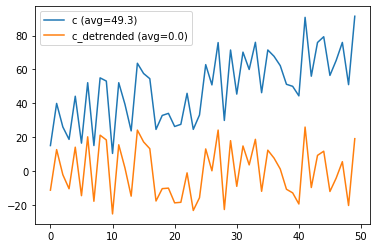

In [27]:
# detrend playground
from scipy import signal
a = np.random.rand(50) * 50
print(a)
b = np.array(range(0,50))
c = a + b

fig, axes = plt.subplots()
# axes.plot(a)
# axes.plot(b)
axes.plot(c, label="c (avg={:0.1f})".format(np.mean(c)))
c_detrended = signal.detrend(c)
axes.plot(c_detrended, label="c_detrended (avg={:0.1f})".format(np.mean(c_detrended)))
axes.legend()


Confusion matrix, without normalization
[[2 0 0]
 [0 1 1]
 [1 0 2]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.5        0.5       ]
 [0.33333333 0.         0.66666667]]


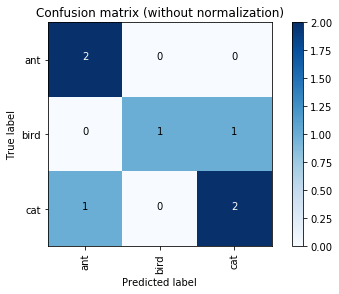

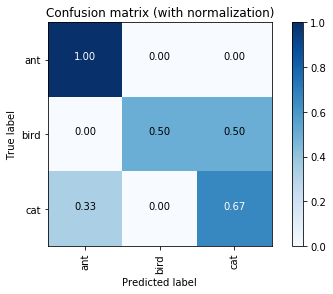

In [28]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ["cat", "ant", "cat", "cat", "ant", "bird", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat", "bird"]
labels=["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()